## <b>Weather forecast project 

# <b>03 - MODEL TRAINING

### Packages nécessaires au notebook :

In [76]:
import numpy as np                                      # Opérations mathématiques 
import pandas as pd                                     # Traitement de données
import matplotlib                                     
import seaborn as sns                                   
import bokeh 
import plotly
import sys
import plotly.express as px                             # Visualisation de données

from sklearn.preprocessing import LabelEncoder          # Encodage de variables catégorielles
from sklearn.model_selection import train_test_split     # Division de données en ensemble d'entraînement et de test
from sklearn.pipeline import Pipeline                   # Création de pipelines
from sklearn.impute import SimpleImputer                 # Imputation des valeurs manquantes
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder # Préparation des données
from sklearn.compose import ColumnTransformer            # Transformation des colonnes du dataframe

# Modélisation 
from sklearn.linear_model import LogisticRegression     # Modélisation
from sklearn.metrics import accuracy_score              # Évaluation de la performance du modèle
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, validation_curve, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from matplotlib.pyplot import figure


import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib") # Suppression des avertissements liés à matplotlib

import geopy.distance                                   # Calcul de distance géographique
from collections import defaultdict                     # Dictionnaire avec valeur par défaut

import geopandas as gpd                                 # Manipulation des données géospatiales
from shapely.geometry import Point                       # Création de géométries de points

from mpl_toolkits.axes_grid1 import make_axes_locatable  # Création de graphiques complexes
from sklearn.neighbors import DistanceMetric             # Calcul de distance entre deux points sur une sphère

from math import radians                                # Conversion degrés en radians

from tqdm import tqdm                                   # Affichage de l'état d'avancement
tqdm.pandas()

import pickle
import time

import lazypredict
from lazypredict.Supervised import LazyClassifier

from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression,f_classif,chi2
from sklearn.feature_selection import SelectKBest, f_regression


In [8]:
df = pd.read_csv("../data/data_features.csv", index_col = 0)


In [9]:
df.head()

,rainfall,evaporation,sunshine,windgustspeed,windspeed9am,windspeed3pm,humidity9am,humidity3pm,pressure3pm,cloud9am,...,climat,geography,position,temp_amplitude,winddir9am_sin,winddir9am_cos,winddir3pm_sin,winddir3pm_cos,windgustdir_sin,windgustdir_cos
0,0.6,7.6,10.9,44.0,20.0,24.0,71.0,22.0,1007.1,8.0,...,0,0,0,9.5,1.224647e-16,-1.000000,0.382683,-0.923880,1.224647e-16,-1.000000
1,0.0,12.0,12.9,44.0,4.0,22.0,44.0,25.0,1007.8,1.0,...,0,0,0,17.7,9.238795e-01,-0.382683,-0.382683,-0.923880,3.826834e-01,-0.923880
2,0.0,8.0,8.0,46.0,19.0,26.0,38.0,30.0,1008.7,7.0,...,0,0,0,12.8,1.224647e-16,-1.000000,-0.382683,-0.923880,-3.826834e-01,-0.923880
3,0.0,10.0,2.2,24.0,11.0,9.0,45.0,16.0,1012.8,8.0,...,0,0,0,18.8,-7.071068e-01,0.707107,0.000000,1.000000,7.071068e-01,0.707107
4,1.0,4.8,6.7,41.0,7.0,20.0,82.0,33.0,1006.0,7.0,...,0,0,0,14.8,3.826834e-01,0.923880,0.707107,-0.707107,1.224647e-16,-1.000000


### Séparation des données en variables explicatives et variable cible

In [59]:
X = df.drop(['raintomorrow'],axis=1)
y = df['raintomorrow']

### Fractionnement des données en ensemble d'entraînement et de test 

In [72]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 10)
# à demander :  choix de randome_state ?

##### Taille des données d'entraînement et de test :

In [56]:
print("Length of Training Data: {}".format(len(X_train)))
print("Length of Testing Data: {}".format(len(X_test)))

Length of Training Data: 58165
Length of Testing Data: 14542


### Evaluation de l'importance des variables explicatives

##### Sélection des K meilleures caractéristiques (SelectKBest)

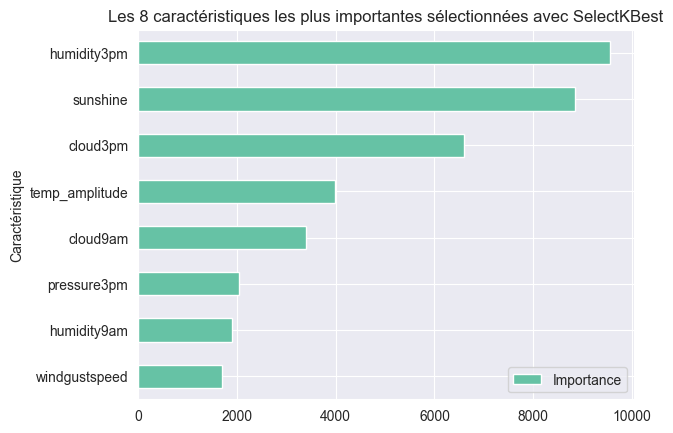

In [65]:
# Sélection des 8 meilleures caractéristiques
selector = SelectKBest(score_func=f_regression, k=8)
selector.fit(X_train, y_train)

# Obtention des noms des colonnes des caractéristiques sélectionnées
selected_features = X_train.columns[selector.get_support()]

# Obtention de l'importance des caractéristiques sélectionnées
feature_scores = selector.scores_[selector.get_support()]

# Création d'un DataFrame pour visualiser les scores des caractéristiques
feature_imp = pd.DataFrame({'Caractéristique': selected_features, 'Importance': feature_scores})
feature_imp = feature_imp.set_index('Caractéristique')

# Affichage d'un graphique horizontal des caractéristiques sélectionnées et leurs scores
feature_imp.nlargest(8, 'Importance').sort_values('Importance', ascending=True).plot(kind='barh')

plt.title('Les 8 caractéristiques les plus importantes sélectionnées avec SelectKBest')
plt.show()

##### Importance des caractéristiques dans un modèle d'arbre de décision 

In [66]:
etr_model = ExtraTreesRegressor()
etr_model.fit(X_train,y_train)
etr_model.feature_importances_

array([0.02116576, 0.03180722, 0.08819574, 0.05252063, 0.02927531,
       0.03061483, 0.03255423, 0.172346  , 0.06975078, 0.02884282,
       0.05580475, 0.00718389, 0.02395754, 0.02639322, 0.03138433,
       0.03106023, 0.03207348, 0.01976737, 0.01152917, 0.01160566,
       0.03040327, 0.02789578, 0.02479968, 0.02964152, 0.02607785,
       0.02750167, 0.02584727])

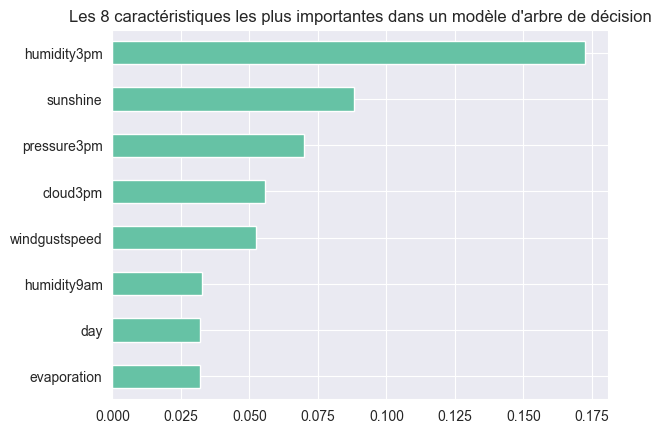

In [68]:
feature_imp = pd.Series(etr_model.feature_importances_,index=X_train.columns)
feature_imp.nlargest(8).sort_values(ascending=True).plot(kind='barh')
plt.title("Les 8 caractéristiques les plus importantes dans un modèle d'arbre de décision")
plt.show()

> La principale différence entre les deux méthodes réside dans leur approche de sélection de caractéristiques. etr_model.feature_importances_ est basé sur la création d'un modèle d'arbre de décision, tandis que SelectKBest utilise des fonctions de score pour évaluer la pertinence des caractéristiques indépendamment du modèle utilisé. En général, SelectKBest est plus approprié pour une utilisation générale, car il n'est pas limité à un modèle spécifique, tandis que etr_model.feature_importances_ est plus approprié pour une utilisation spécifique à un modèle d'arbre de décision.

### Normalisation des données :

In [69]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Aperçu rapide des modèles avec LazyClassifier

In [25]:
clf = LazyClassifier(ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [1:12:31<00:00, 150.06s/it]  


In [26]:
print(models)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.74               0.75     0.75      0.78   
QuadraticDiscriminantAnalysis      0.81               0.74     0.74      0.83   
GaussianNB                         0.81               0.73     0.73      0.82   
XGBClassifier                      0.89               0.72     0.72      0.88   
BernoulliNB                        0.79               0.71     0.71      0.81   
LGBMClassifier                     0.89               0.70     0.70      0.87   
LinearDiscriminantAnalysis         0.87               0.69     0.69      0.86   
LabelPropagation                   0.84               0.69     0.69      0.84   
RandomForestClassifier             0.89               0.69     0.69      0.87   
BaggingClassifier                  0.88               0.68     0.68      0.86   
ExtraTreesClassifier        

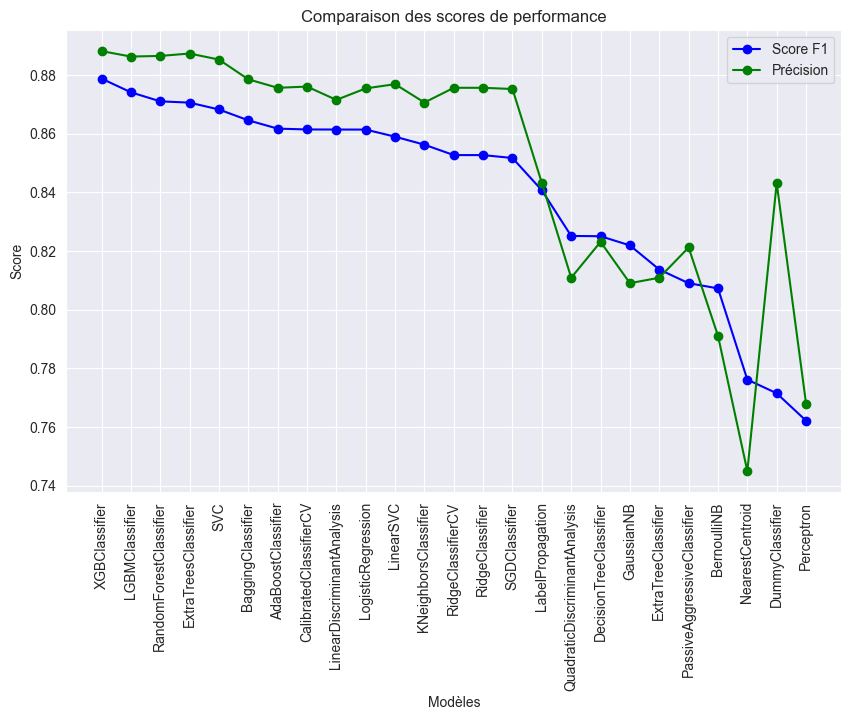

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

# Convertir les scores de performance en listes
models_list = list(models.index)
accuracy_list = list(models['Accuracy'])
f1_score_list = list(models['F1 Score'])

# Trier les listes par ordre décroissant de score F1
sorted_indices = np.argsort(f1_score_list)[::-1]
models_list = [models_list[i] for i in sorted_indices]
accuracy_list = [accuracy_list[i] for i in sorted_indices]
f1_score_list = [f1_score_list[i] for i in sorted_indices]

# Tracer la courbe de performance
plt.figure(figsize=(10, 6))
plt.plot(models_list, f1_score_list, '-o', color='blue', label='Score F1')
plt.plot(models_list, accuracy_list, '-o', color='green', label='Précision')
plt.xlabel('Modèles')
plt.ylabel('Score')
plt.title('Comparaison des scores de performance')
plt.xticks(rotation=90)
plt.legend()
plt.show()

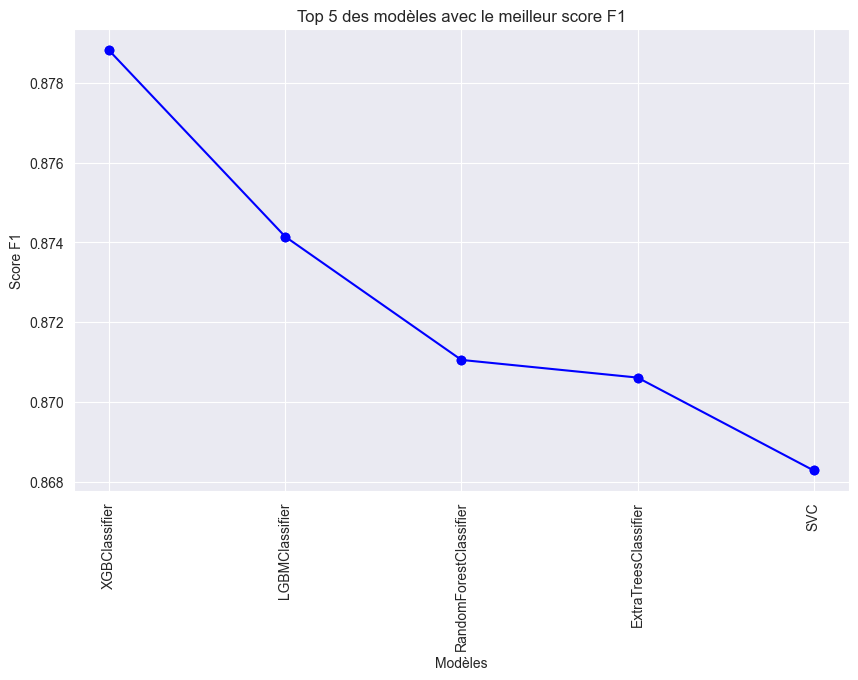

In [29]:
# Tracer la courbe de performance pour les 5 meilleurs modèles
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot([models_list[i]], [f1_score_list[i]], 'o', color='blue')
plt.plot(models_list[:5], f1_score_list[:5], '-o', color='blue')
plt.xlabel('Modèles')
plt.ylabel('Score F1')
plt.title('Top 5 des modèles avec le meilleur score F1')
plt.xticks(rotation=90)
plt.show()